In [ ]:
import pandas as pd  # For data manipulation and analysis with DataFrames
import numpy as np   # For efficient numerical computations and array operations
import keras  # High-level neural networks API (TensorFlow backend)
import tensorflow as tf  # For building neural networks
import shap  # SHapley Additive exPlanations for model interpretability
import os  # Operating system interfaces for file/directory operations
from pathlib import Path  # Object-oriented filesystem paths
import joblib  # Efficient saving/loading of Python objects (especially scikit-learn models)
from keras.models import Sequential, load_model, Model  # Model architectures
from keras.layers import (
    Input, Conv1D, GlobalAveragePooling1D, Flatten, Dense, 
    Dropout, BatchNormalization, MaxPooling1D, Reshape, 
    Average, Concatenate, ZeroPadding1D
)  
from keras.callbacks import EarlyStopping  # Stop training when validation loss stops improving
from keras import regularizers  # Regularization techniques
from keras.regularizers import l2  # L2 regularization implementation
import matplotlib.pyplot as plt  # Comprehensive plotting library

c:\Users\z003pprh\OneDrive - Siemens AG\Dokumenty\osu\bakalářka\vypracování\VUPS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed for reproducibility across NumPy, Python, and TensorFlow
keras.utils.set_random_seed(42)

In [3]:
# Apply working directory
project_root = Path.cwd() 
os.chdir(project_root)
print(f"Set working directory to: {project_root}")

Set working directory to: c:\Users\z003pprh\OneDrive - Siemens AG\Dokumenty\osu\bakalářka\vypracování\VUPS\VUPS_BC_Leskovský\v2


In [ ]:
# Loading the dataset from a CSV file
train = pd.read_csv("data/train_scaled.csv", delimiter=',')
test = pd.read_csv("data/test_scaled.csv", delimiter=',')

# Shuffle training data
train = train.sample(frac=1).reset_index(drop=True)

# Shuffle test data
test = test.sample(frac=1).reset_index(drop=True)

# Display first few rows of training data
train.head()

,score,extrakt_zdanlivy,extrakt_skutecny,alhokol_hm,alkohol_obj,extrakt_puvodni_mladiny,prokvaseni_zdanlive,prokvaseni_skutecne,ibu,ph,...,c_122,c_123,c_124,c_125,c_126,c_134,c_136,c_138,c_139,c_140
0,0.4923,0.785799,0.760705,0.053985,0.085470,0.593099,0.066452,0.043533,0.201564,0.358320,...,0.518496,0.226610,0.383616,0.461558,0.702198,0.304087,0.432599,0.105248,0.430142,0.462373
1,0.5538,0.638443,0.629821,0.257069,0.151709,0.486003,0.174707,0.154571,0.403197,0.594728,...,0.176960,0.214365,0.248688,0.314347,0.235558,0.300713,0.186139,0.074557,0.452358,0.564446
2,0.4462,0.620024,0.638324,0.717224,0.869658,0.701497,0.609588,0.536692,0.917866,0.558484,...,0.310909,0.095668,0.383378,0.249886,0.226911,0.498869,0.264920,0.419303,0.838842,0.513424
3,0.3077,0.226976,0.217127,0.508997,0.487179,0.162435,0.617939,0.492499,0.551550,0.216639,...,0.118938,0.793407,0.086271,0.166235,0.072105,0.479126,0.609485,0.501426,0.582715,0.347788
4,0.5846,0.999406,0.972669,0.023136,0.085470,0.872070,0.014639,0.070444,0.848464,0.253707,...,0.000000,0.984000,0.371161,0.219073,0.248938,0.428672,0.000000,0.043725,0.704400,0.481794


In [11]:
# Separate inputs and outputs
Y_train = train['score']
X_train = train.drop(columns=['score'])

Y_test = test['score'] 
X_test = test.drop(columns=['score'])

# Check results
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((170, 248), (170,), (50, 248), (50,))

## Build DNN_model

In [ ]:
#model_DNN = load_model('models/model_DNN.keras')

In [ ]:
#Set seed for reproducibility across runs
keras.utils.set_random_seed(42)
 
#Define the deep neural network architecture
model_DNN = Sequential()

#Input layer with 248 units + normalization
model_DNN.add(Dense(248, activation='relu'))
model_DNN.add(BatchNormalization())

#Hidden layer with 124 units + L1/L2 regularization + normalization + dropout
model_DNN.add(Dense(124, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5)))
model_DNN.add(BatchNormalization())
model_DNN.add(Dropout(0.6))

#Hidden layer with 62 units + regularization + normalization
model_DNN.add(Dense(62, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5)))
model_DNN.add(BatchNormalization())

#Hidden layer with 30 units + regularization + normalization + dropout
model_DNN.add(Dense(30, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5)))
model_DNN.add(BatchNormalization())
model_DNN.add(Dropout(0.2))

#Hidden layer with 15 units + regularization + normalization
model_DNN.add(Dense(15, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5)))
model_DNN.add(BatchNormalization())

#Output layer with sigmoid activation (for scaled regression target)
model_DNN.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5)))

#Compile the model with RMSprop optimizer and MSE loss
model_DNN.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

#Train the model
#history = model_DNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=0)
# Early stopping
early_stopping = EarlyStopping(monitor='val_mse', patience=150, restore_best_weights=True)
history = model_DNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=250, verbose=0, callbacks=[early_stopping])

#Optional: Save and load the model
# model_DNN.save('model_DNN.keras')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


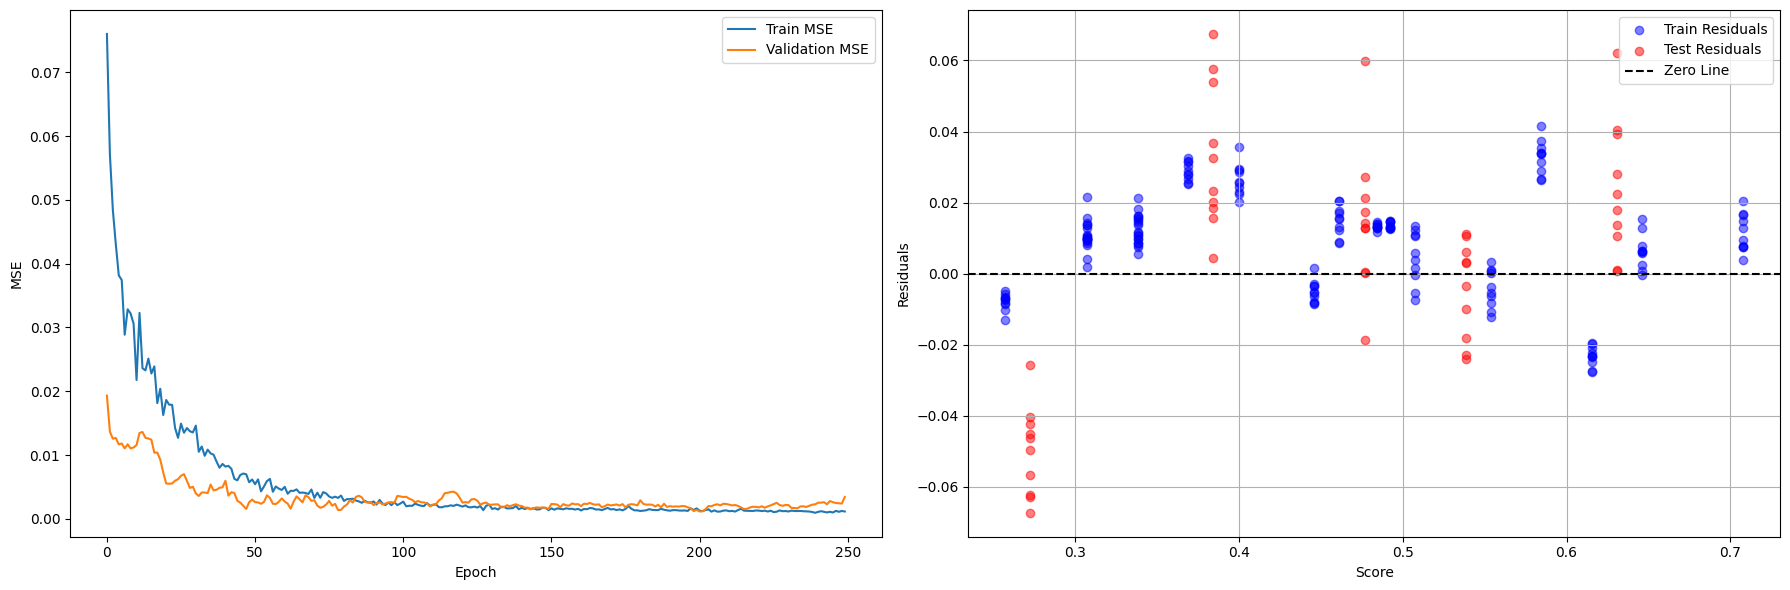

In [ ]:
#Make predictions
Y_train_pred = model_DNN.predict(X_train).flatten()
Y_test_pred = model_DNN.predict(X_test).flatten()

#Calculate residuals
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

#Sort values for clearer plots
sorted_indices_train = np.argsort(Y_train)
sorted_indices_test = np.argsort(Y_test)

Y_train_sorted = Y_train.iloc[sorted_indices_train]
residuals_train_sorted = residuals_train.iloc[sorted_indices_train]

Y_test_sorted = Y_test.iloc[sorted_indices_test]
residuals_test_sorted = residuals_test.iloc[sorted_indices_test]

#Plot MSE and residual analysis
plt.figure(figsize=(18, 6))

#Subplot 1: MSE over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

#Subplot 2: Residuals visualization
plt.subplot(1, 2, 2)
plt.scatter(Y_train_sorted, residuals_train_sorted, alpha=0.5, label='Train Residuals', color='blue')
plt.scatter(Y_test_sorted, residuals_test_sorted, alpha=0.5, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.xlabel('Score')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

#Display plots
plt.tight_layout()
plt.show()


## Build CNN_model

In [ ]:
#model_CNN = load_model('models/model_CNN.keras')

In [ ]:
#Ensure reproducible results
keras.utils.set_random_seed(42)

#Build the Sequential CNN model
model_CNN = Sequential()

#Input reshaping for Conv1D
model_CNN.add(Input(shape=(X_train.shape[1],)))
model_CNN.add(Reshape((X_train.shape[1], 1)))

#Conv block 1
model_CNN.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', strides=1))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.13))

#Conv block 2
model_CNN.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', strides=1))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.72))

#Conv block 3 with regularization
model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', strides=1,
                 kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-5)))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.8))

#Global pooling + output layer
model_CNN.add(GlobalAveragePooling1D())
model_CNN.add(Dense(1, activation='sigmoid',
                kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))

#Compile with AdamW optimizer and MSE loss
model_CNN.compile(optimizer='adamw', loss='mean_squared_error', metrics=['mse'])

#Train the model
#history = model_CNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=0)
# Early stopping
early_stopping = EarlyStopping(monitor='val_mse', patience=500, restore_best_weights=True)
history = model_CNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1500, verbose=0, callbacks=[early_stopping])

#Optional: Save and load the model
# model_CNN.save('model_CNN.keras')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


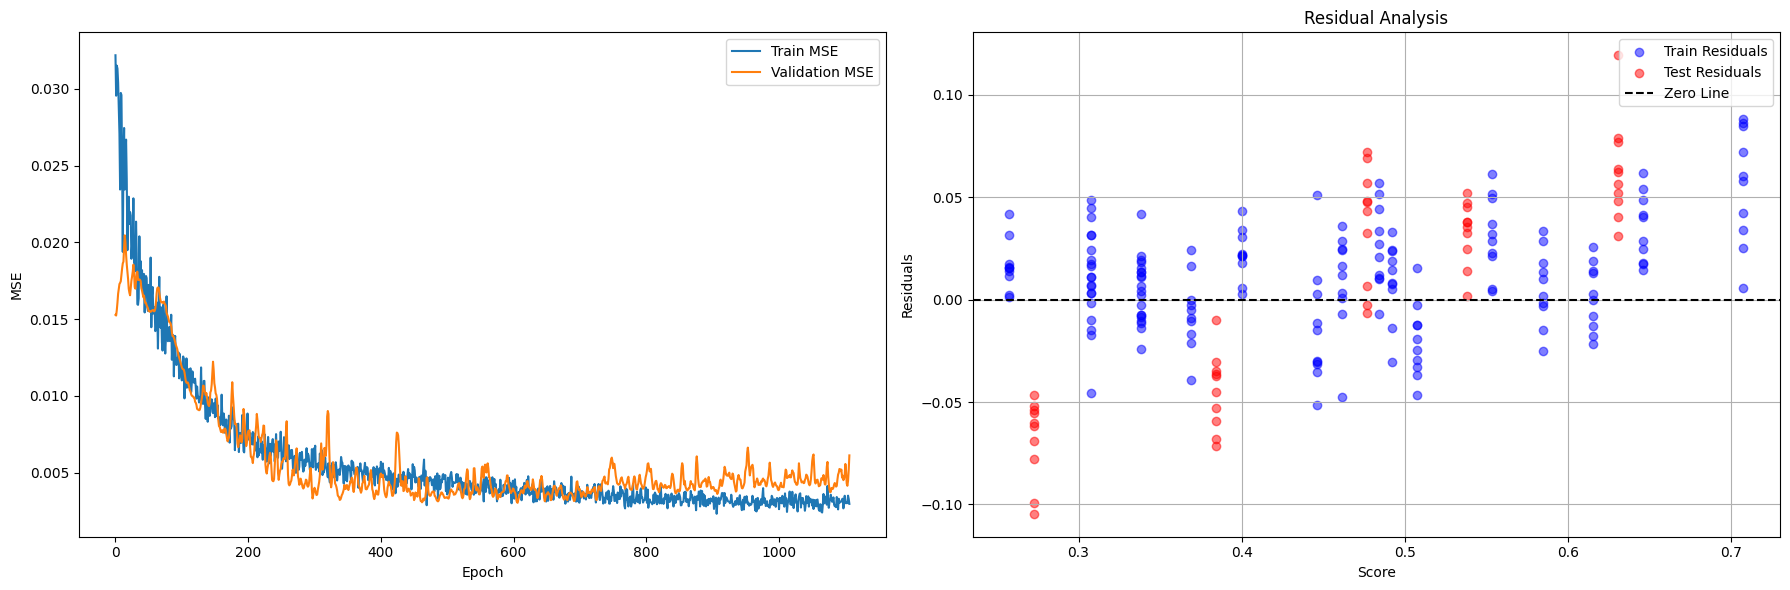

In [ ]:
#Predict outputs
Y_train_pred = model_CNN.predict(X_train).flatten()
Y_test_pred = model_CNN.predict(X_test).flatten()

#Calculate residuals
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

#Sort for smoother plotting
sorted_indices_train = np.argsort(Y_train)
sorted_indices_test = np.argsort(Y_test)

Y_train_sorted = Y_train.iloc[sorted_indices_train]
residuals_train_sorted = residuals_train.iloc[sorted_indices_train]
Y_test_sorted = Y_test.iloc[sorted_indices_test]
residuals_test_sorted = residuals_test.iloc[sorted_indices_test]

#Visualizations: MSE progression & residual analysis
plt.figure(figsize=(18, 6))

#Subplot 1: Train & validation MSE over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

#Subplot 2: Residuals scatter plot
plt.subplot(1, 2, 2)
plt.scatter(Y_train_sorted, residuals_train_sorted, alpha=0.5, label='Train Residuals', color='blue')
plt.scatter(Y_test_sorted, residuals_test_sorted, alpha=0.5, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.xlabel('Score')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.legend()
plt.grid(True)

#Display plots
plt.tight_layout()
plt.show()

## Build db_NN_model

In [ ]:
#model_db_NN = load_model('models/model_db_NN.keras')

In [ ]:
#Set random seed for reproducibility
keras.utils.set_random_seed(42)

#Input layer reshaped for 1D convolution
input_layer = Input(shape=(X_train.shape[1],))
x = Reshape((X_train.shape[1], 1))(input_layer)

#Shared initial Conv block
x = Conv1D(filters=16, kernel_size=9, activation='elu', padding='valid', strides=1)(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#Branch 1: deeper Conv blocks with regularization
branch11 = Conv1D(filters=32, kernel_size=9, activation='elu', padding='valid', strides=1)(x)
branch11 = MaxPooling1D(pool_size=2)(branch11)
branch11 = BatchNormalization()(branch11)
branch11 = Dropout(0.1)(branch11)

branch12 = Conv1D(filters=64, kernel_size=9, activation='elu', padding='valid', strides=1,
                  kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-6))(branch11)
branch12 = MaxPooling1D(pool_size=2)(branch12)
branch12 = BatchNormalization()(branch12)
branch12 = Dropout(0.2)(branch12)

#Padding to match shape for concatenation
branch12_padded = ZeroPadding1D(padding=(0, 34))(branch12)

#Branch 2: alternative Conv path
branch21 = Conv1D(filters=64, kernel_size=5, activation='elu', padding='valid', strides=1,
                  kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-6))(x)
branch21 = MaxPooling1D(pool_size=2)(branch21)
branch21 = BatchNormalization()(branch21)
branch21 = Dropout(0.8)(branch21)

#Merge branches + normalization
merged = Concatenate()([branch12_padded, branch21])
merged = BatchNormalization()(merged)

#Flatten and output layer
x = Flatten()(merged)
output = Dense(1, activation='elu')(x)

#Build the model
model_db_NN = Model(inputs=input_layer, outputs=output)

#Compile with Adamax optimizer and MSE loss
model_db_NN.compile(optimizer='adamax', loss='mean_squared_error', metrics=['mse'])

#Train the model
#history = model_db_NN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=0)
# Early stopping
early_stopping = EarlyStopping(monitor='val_mse', patience=500, restore_best_weights=True)
history = model_db_NN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1500, verbose=0, callbacks=[early_stopping])

#Optional: save/load model
# model_db_NN.save('model_db_NN.keras')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


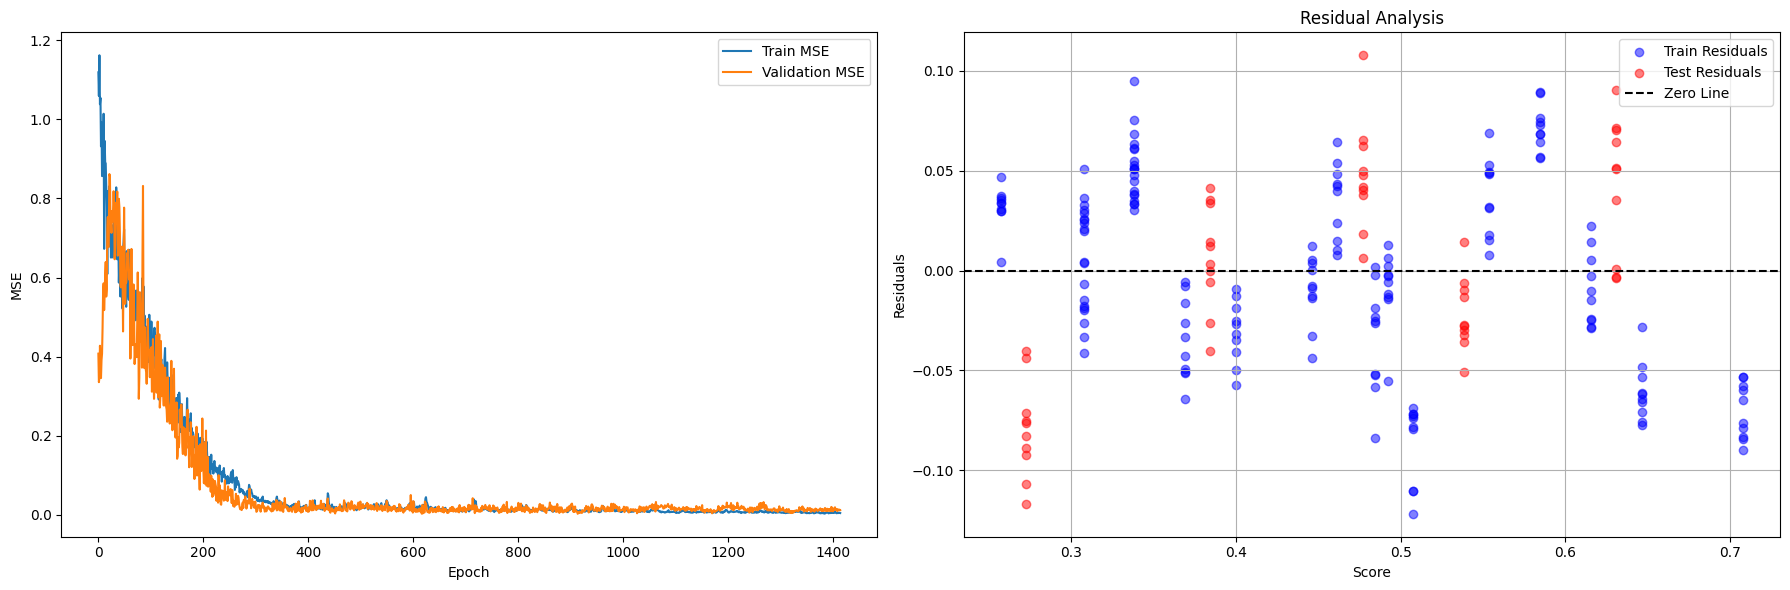

In [ ]:
#Predict outputs
Y_train_pred = model_db_NN.predict(X_train).flatten()
Y_test_pred = model_db_NN.predict(X_test).flatten()

#Calculate residuals
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

#Sort for smoother plotting
sorted_indices_train = np.argsort(Y_train)
sorted_indices_test = np.argsort(Y_test)

Y_train_sorted = Y_train.iloc[sorted_indices_train]
residuals_train_sorted = residuals_train.iloc[sorted_indices_train]
Y_test_sorted = Y_test.iloc[sorted_indices_test]
residuals_test_sorted = residuals_test.iloc[sorted_indices_test]

#Visualizations: MSE progression & residual analysis
plt.figure(figsize=(18, 6))

#Subplot 1: Train & validation MSE over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

#Subplot 2: Residuals scatter plot
plt.subplot(1, 2, 2)
plt.scatter(Y_train_sorted, residuals_train_sorted, alpha=0.5, label='Train Residuals', color='blue')
plt.scatter(Y_test_sorted, residuals_test_sorted, alpha=0.5, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.xlabel('Score')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.legend()
plt.grid(True)

#Display plots
plt.tight_layout()
plt.show()

## Build Ensemble_model

In [ ]:
#Define input shape
shared_input_shape = model_DNN.input_shape[1:]

#Create a shared input layer
shared_input = Input(shape=shared_input_shape)

#Connect each sub-model to the shared input
# All sub-models must be compatible and already trained or compiled
cnn_output = model_CNN(shared_input)
dnn_output = model_DNN(shared_input)
db_nn_output = model_db_NN(shared_input)

#Average predictions for consensus output
averaged_output = Average()([cnn_output, dnn_output, db_nn_output])

#Build the final ensemble model
ensemble_model = Model(inputs=shared_input, outputs=averaged_output)

#Compile the ensemble model
ensemble_model.compile(loss='mse')

#Optional: save/load model
# ensemble_model.save('ensemble_model.keras')

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step

c:\Users\z003pprh\OneDrive - Siemens AG\Dokumenty\osu\bakalářka\vypracování\VUPS\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_465
Received: inputs=('Tensor(shape=(32, 248))',)
  warnings.warn(msg)
c:\Users\z003pprh\OneDrive - Siemens AG\Dokumenty\osu\bakalářka\vypracování\VUPS\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_465
Received: inputs=('Tensor(shape=(None, 248))',)
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


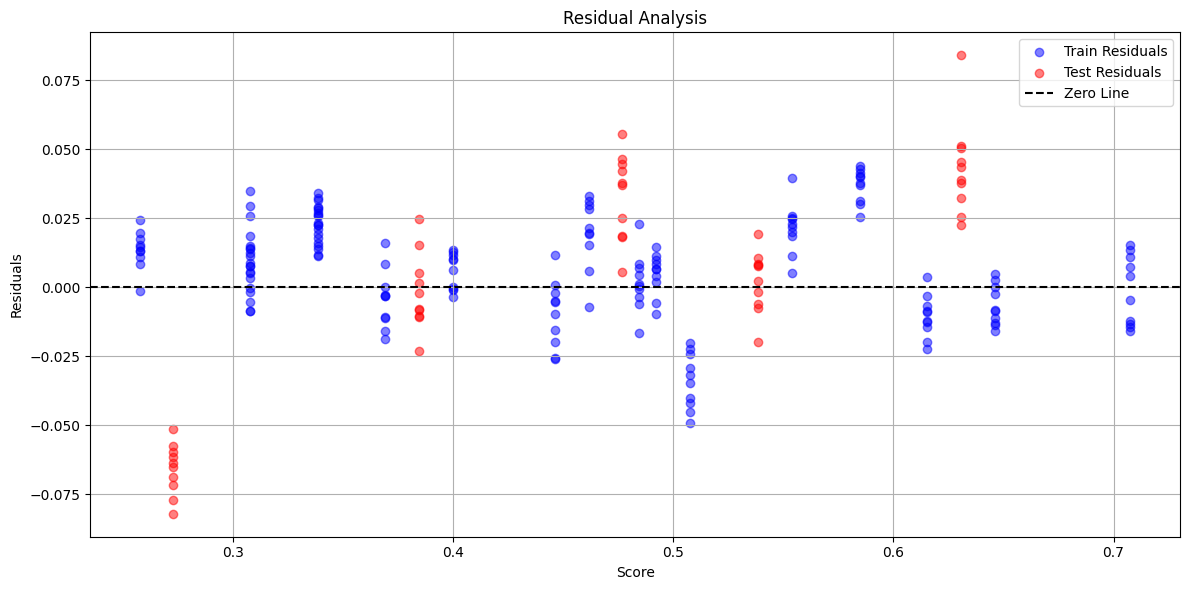

In [ ]:
#Predict using the ensemble model
Y_train_pred = ensemble_model.predict([X_train]).flatten()
Y_test_pred = ensemble_model.predict([X_test]).flatten()

#Compute residuals (true - predicted)
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

#Sort values for smoother visualization
sorted_indices_train = np.argsort(Y_train)
sorted_indices_test = np.argsort(Y_test)

Y_train_sorted = Y_train.iloc[sorted_indices_train]
residuals_train_sorted = residuals_train.iloc[sorted_indices_train]

Y_test_sorted = Y_test.iloc[sorted_indices_test]
residuals_test_sorted = residuals_test.iloc[sorted_indices_test]

#Plot residuals for train and test sets
plt.figure(figsize=(12, 6))
plt.scatter(Y_train_sorted, residuals_train_sorted, alpha=0.5, label='Train Residuals', color='blue')
plt.scatter(Y_test_sorted, residuals_test_sorted, alpha=0.5, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.xlabel('Score')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Combine X_train and X_test vertically (i.e., append rows)
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

#Initialize KernelExplainer with a small sample of the training data as reference (background data)
##explainer = shap.KernelExplainer(ensemble_model, X_train.sample(n=10))

#Generate SHAP values for the full training set without regularization
##shap_values = explainer(X_test, l1_reg=False)
shap_values = joblib.load("shap/shap_values.pkl")

#Save computed SHAP values for future analysis or sharing
##joblib.dump(shap_values, 'shap_values.pkl')